In [44]:
import pickle
import datetime

from sqlalchemy import text, bindparam, ARRAY, String
import numpy as np
from matplotlib import pyplot as plt
import tikzplotlib

from shared.models import UserTweetCounts, row_to_obj
from shared.db import run_query

In [46]:

START = '2006-01-01 00:00'
END = '2022-12-31 23:59'
BUCKET_SIZE = '1 year'

MAX_USER_TWEETS_PER_DAY = 100
MIN_USER_CDR_TWEETS = 2

print('Loading user data')
with open('data/user_stats.pkl', 'rb') as f:
    data: list[dict] = pickle.load(f)
print('Prepping filter stats')
user_ids = [d['twitter_author_id'] for d in data]
n_tweets = np.array([d['num_tweets'] for d in data])
lifetime = np.array([(datetime.datetime(2022, 12, 31, 23, 59) - d['created_at']).days for d in data])
tpd = n_tweets / lifetime
n_cdr_tweets = np.array([d['num_cdr_tweets_noccs'] for d in data])

TECHNOLOGIES = [
    # 'Methane Removal', # 0
    # 'CCS', # 1
    'Ocean Fertilization',  # 2
    'Ocean Alkalinization',  # 3
    'Enhanced Weathering',  # 4
    'Biochar',  # 5
    'Afforestation/Reforestation',  # 6
    'Ecosystem Restoration',  # 7
    'Soil Carbon Sequestration',  # 8
    'BECCS',  # 9
    'Blue Carbon',  # 10
    'Direct Air Capture',  # 11
    'GGR (general)'  # 12
]

Loading user data
Prepping filter stats


In [47]:
stmt = text('''
            WITH buckets as (SELECT generate_series(:start_time ::timestamp,
                                                    :end_time ::timestamp,
                                                    :bucket_size) as bucket),
                 tweets as (SELECT ut.twitter_id, ut.twitter_author_id, ut.created_at, ba_tech.value_int as technology
                            FROM twitter_item ut
                                     LEFT JOIN bot_annotation ba_tech ON (
                                        ut.item_id = ba_tech.item_id
                                    AND ba_tech.bot_annotation_metadata_id = :ba_tech
                                    AND ba_tech.key = 'tech')
                            WHERE project_id = :project_id),
                 users as (SELECT unnest(:user_ids) as author_id)
            SELECT b.bucket                                                                        as bucket,
                   count(DISTINCT ti.twitter_id)                                                   as num_tweets,
                   --count(DISTINCT ut.twitter_id) FILTER (WHERE ba.value_int = 0)                  as "Methane Removal",
                   --count(DISTINCT ut.twitter_id) FILTER (WHERE ba.value_int = 1)                  as "CCS",
                   count(DISTINCT ti.twitter_id) FILTER (WHERE ti.technology = 2)                  as "Ocean Fertilization",
                   count(DISTINCT ti.twitter_id) FILTER (WHERE ti.technology = 3)                  as "Ocean Alkalinization",
                   count(DISTINCT ti.twitter_id) FILTER (WHERE ti.technology = 4)                  as "Enhanced Weathering",
                   count(DISTINCT ti.twitter_id) FILTER (WHERE ti.technology = 5)                  as "Biochar",
                   count(DISTINCT ti.twitter_id) FILTER (WHERE ti.technology = 6)                  as "Afforestation/Reforestation",
                   count(DISTINCT ti.twitter_id) FILTER (WHERE ti.technology = 7)                  as "Ecosystem Restoration",
                   count(DISTINCT ti.twitter_id) FILTER (WHERE ti.technology = 8)                  as "Soil Carbon Sequestration",
                   count(DISTINCT ti.twitter_id) FILTER (WHERE ti.technology = 9)                  as "BECCS",
                   count(DISTINCT ti.twitter_id) FILTER (WHERE ti.technology = 10)                 as "Blue Carbon",
                   count(DISTINCT ti.twitter_id) FILTER (WHERE ti.technology = 11)                 as "Direct Air Capture",
                   count(DISTINCT ti.twitter_id) FILTER (WHERE ti.technology = 12)                 as "GGR (general)"

            FROM buckets b
                     LEFT OUTER JOIN tweets ti ON (
                        ti.created_at >= b.bucket
                    AND ti.created_at < (b.bucket + :bucket_size ::interval))
                     LEFT OUTER JOIN users u ON ti.twitter_author_id = u.author_id
            WHERE ti.twitter_author_id = u.author_id AND ti.technology > 1
            GROUP BY b.bucket;
            ''')
stmt = stmt.bindparams(
    bindparam('user_ids', type_=ARRAY(String), value=[uid for uid, m in zip(user_ids, mask) if m]),
)

print('Running query')
result = run_query(stmt, {
    'project_id': 'c5d36b2e-cbb4-47a8-8370-e5f52bb78bf3',
    'ba_tech': 'fc73da56-9f51-4d2b-ad35-2a01dbe9b275',
    'bucket_size': BUCKET_SIZE,
    'start_time': START,
    'end_time': END,
    'user_ids': tuple([uid for uid, m in zip(user_ids, mask) if m])
})

Running query


Preparing results
Making figure


/tmp/ipykernel_9049/4103820923.py:26: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


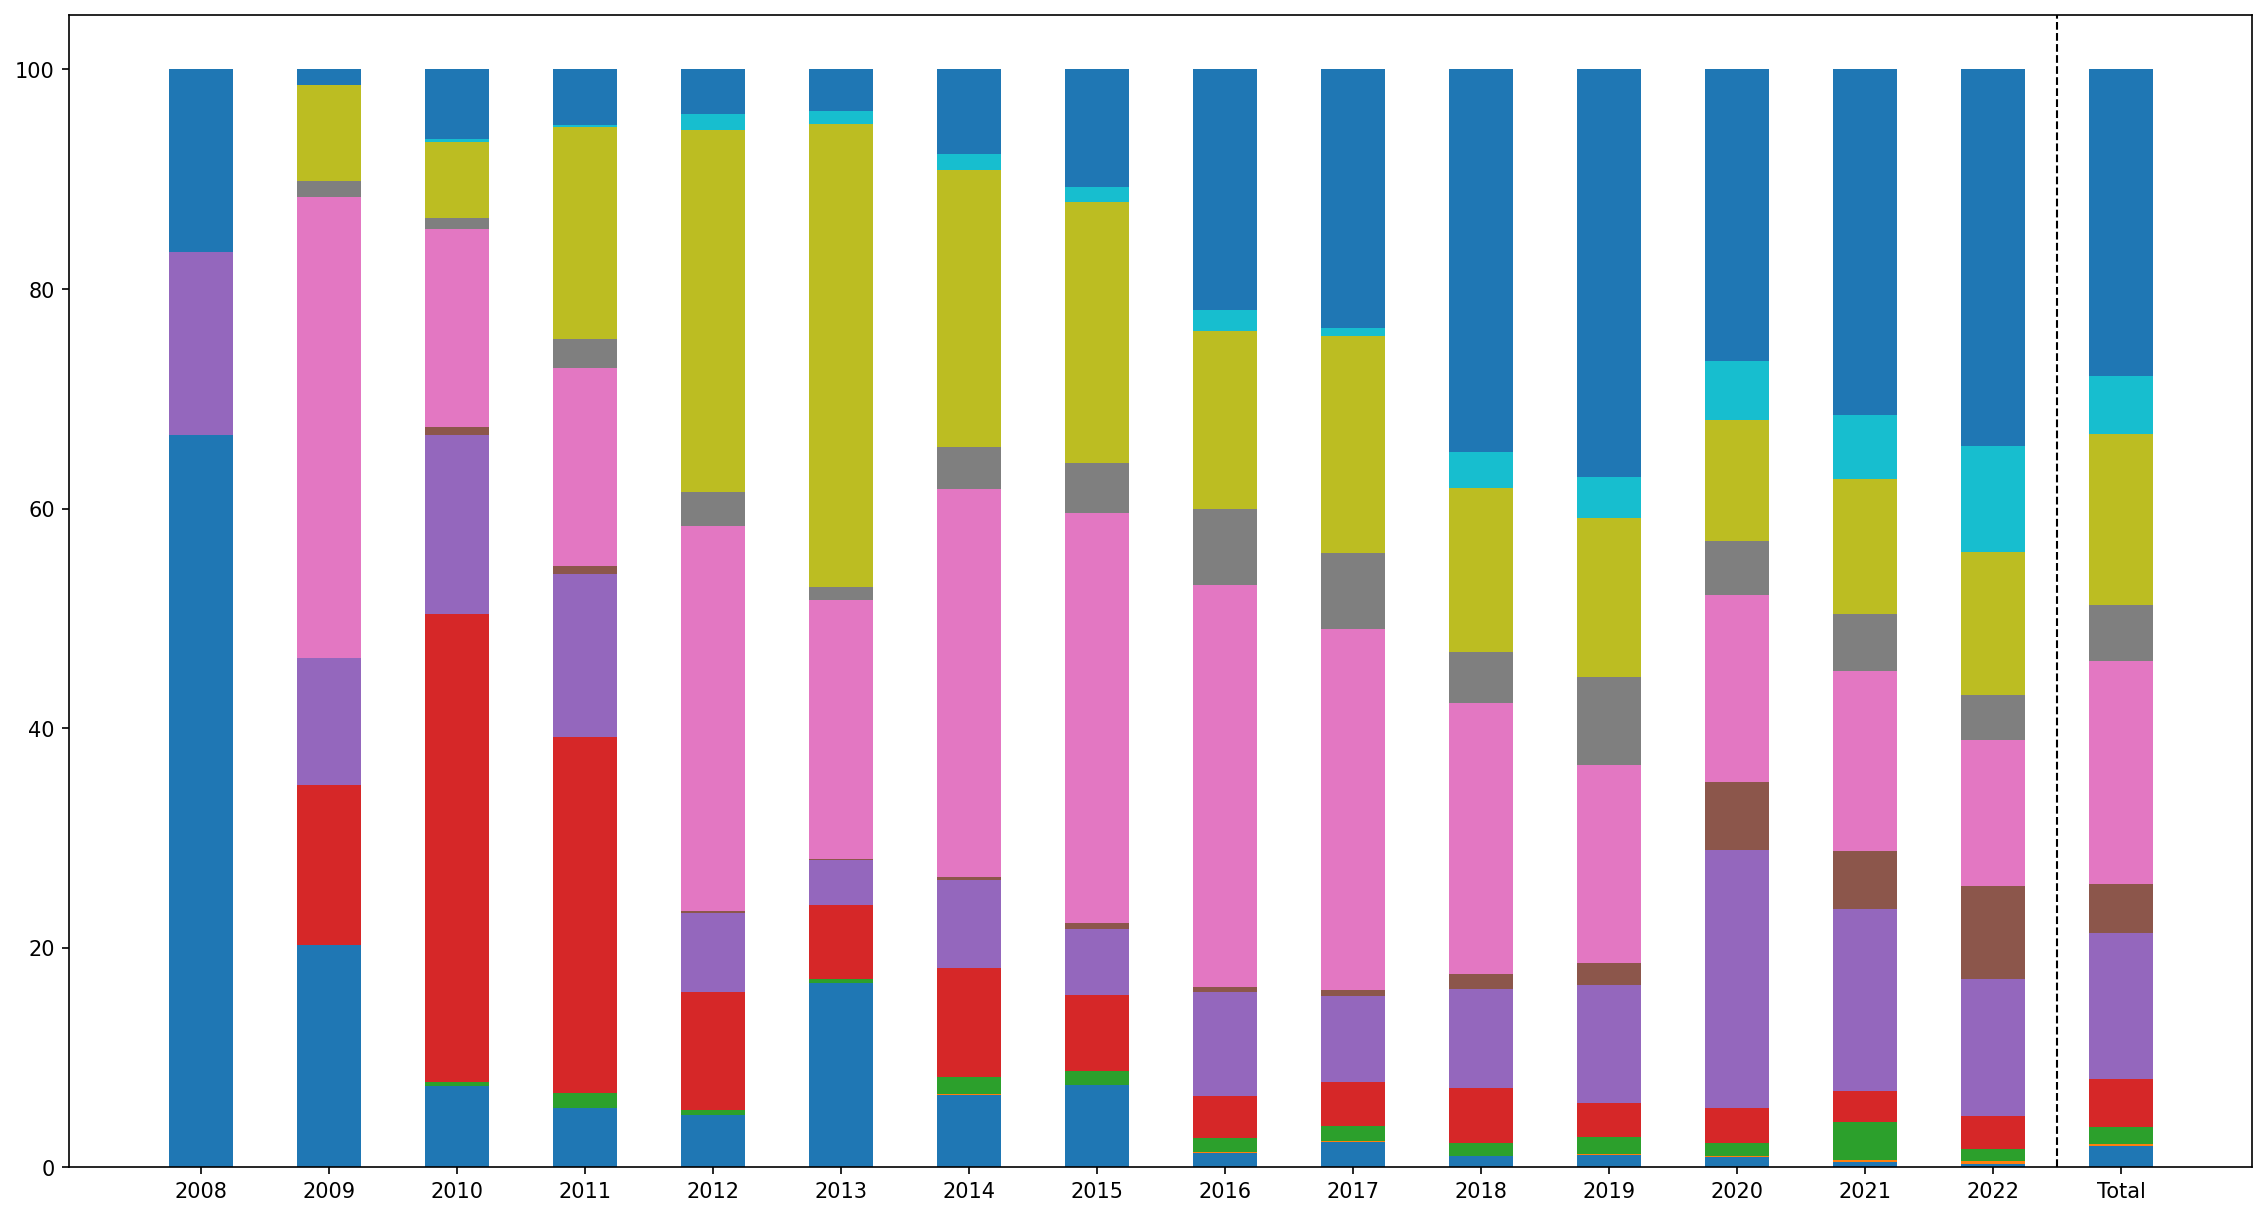

In [57]:

print('Preparing results')
buckets = [str(r['bucket'].year) for r in result] + ['Total']
num_tweets = np.array([r['num_tweets'] for r in result])
stack_totals = np.zeros(len(buckets))
tech_counts = {}
for technology in TECHNOLOGIES:
    tech_counts[technology] = np.array([r[technology] for r in result])
    tech_counts[technology] = np.hstack([tech_counts[technology], tech_counts[technology].sum()])
    stack_totals += tech_counts[technology]

print('Making figure')
fig: plt.Figure
axes: list[list[plt.Axes]]
fig, ax = plt.subplots(figsize=(15, 8), dpi=150, layout='constrained')  # width/height

bottom = np.zeros(len(buckets))
width = 0.5
for technology in TECHNOLOGIES:
    normed = (tech_counts[technology] / stack_totals) * 100
    # normed = (tech_counts[technology] /  num_tweets) * 100  # FIXME for some reason, slightly off 100%
    ax.bar(buckets, normed, width, label=technology, bottom=bottom)  # , color='#FF7F0E')
    bottom += normed

ax.axvline(len(buckets)-1.5, linewidth=1, color='black', ls='--')

fig.show()